# Langgraph Tool 활용 기초

In [1]:
import keyring
import os
OPENPI_API_KEY = keyring.get_password('openai', 'key_for_windows')
os.environ['OPENAI_API_KEY'] = OPENPI_API_KEY

In [ ]:
from langchain_core.messages import AIMessage
from langchain_core.tools import tool

# tool을 노드에서 활용하기 위한 라이브러리
from langgraph.prebuilt import ToolNode

# Langgraph Custom Tool 선언

In [3]:
# langchain_core.tools의 tool을 import하면 @tool 데코레이터만으로 함수를 langchain의 tool로 변환할 수 있습니다.
# 아래 날씨 관련 함수들은 임의의 로직이므로, 실제 함수는 API를 포함한 로직이 들어가면 됩니다.

@tool
def get_weather(location: str):
    """Call to get the weather"""
    if location in ["서울", "인천"]:
        return "It's 60's degrees and foggy."
    else:
        return "It's 90 degrees and sunny."
    
@tool
def get_coolest_cities():
    """Get a list of coolest cities"""
    return "서울, 고성"

In [4]:
# Tool Node로 묶어줄 때, 리스트 형태로 tool들을 함께 제공합니다.
tools = [get_weather, get_coolest_cities]
tool_node = ToolNode(tools)

In [ ]:
# bind_tools()함수로 LLM에게 어떤 tool들이 있는지 인지시켜 도구의 활용하도록 만듭니다.
from langchain_openai import ChatOpenAI

model_with_tools = ChatOpenAI(
    model='gpt-4o-mini',
    temperature=0
).bind_tools(tools)     # 도구들에 대한 힌트를 주기 위해 .bind_tools 메서드 호출

In [ ]:
# tool 호출 확인
model_with_tools.invoke("서울 날씨는 어떄?").tool_calls

[{'name': 'get_weather',
  'args': {'location': '서울'},
  'id': 'call_JQ3cwiAq7a4YJZKTNwQ1w0QU',
  'type': 'tool_call'}]

In [7]:
model_with_tools.invoke("한국에서 가장 추운 도시는?").tool_calls

[{'name': 'get_coolest_cities',
  'args': {},
  'id': 'call_9DFdjPkmjVGdMca5u98CU9W2',
  'type': 'tool_call'}]

In [16]:
model_with_tools.invoke("대한민국 대통령은 누구야?").tool_calls

[]

In [ ]:
# tool_node 실행해보기
tool_node.invoke({"messages": [model_with_tools.invoke("서울 날씨는 어때?")]})

{'messages': [ToolMessage(content="It's 60's degrees and foggy.", name='get_weather', tool_call_id='call_GM9tXIpqlroKdiBwBD802qDj')]}

# 노드, 엣지를 선언하고 그래프 정의하기

In [ ]:
from typing import Annotated, Literal, TypedDict
from langchain_core.messages import HumanMessage
from langchain_core.tools import tool
from langgraph.graph import END, START, StateGraph, MessagesState


# should_continue라는 함수에 따라 agent 노드에서 tool 혹은 END로 진입
# conditional edge와 동일한 역할
def should_continue(state: MessagesState) -> Literal["tools", END]:
    messages = state['messages']
    last_message = messages[-1]
    if last_message.tool_calls:
        return 'tools'
    return END
 
def call_model(state: MessagesState):
    messages = state['messages']
    response = model_with_tools.invoke(messages)
    return {"messages": [response]}


workflow = StateGraph(MessagesState)

workflow.add_node('agent', call_model)
workflow.add_node('tools', tool_node)

workflow.add_edge(START, 'agent') 

# add_conditional_edges는 조건부 엣지 추가 함수

workflow.add_conditional_edges(
    "agent",
    should_continue,    # 조건부 분기
)

workflow.add_edge('tools', 'agent')     # 툴 결과는 항상 에이전트로 전달달

app = workflow.compile()
    

# 그래프 시각화

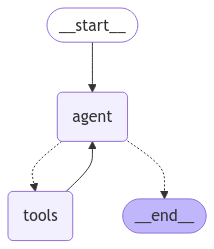

In [13]:
from IPython.display import Image, display

try:
    display(Image(app.get_graph().draw_mermaid_png()))
except Exception as e:
    # This requires some extra dependencies and is optional
    print(e)
    pass

# invoke 함수로 그래프 호출하기

In [14]:
final_state = app.invoke(
    {"messages": [HumanMessage(content="서울의 날씨는 어떄?")]}
)
final_state["messages"][-1].content

'서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다.'

In [15]:
# example with a multiple tool calls in succession

for chunk in app.stream(
    {"messages": [("human", "가장 추운 도시의 날씨는 어떄?")]},
    stream_mode="values",
):
    chunk['messages'][-1].pretty_print()

================================ Human Message =================================

가장 추운 도시의 날씨는 어떄?
================================== Ai Message ==================================
Tool Calls:
  get_coolest_cities (call_ePjNGzVYARDNESel5ygxvuDR)
 Call ID: call_ePjNGzVYARDNESel5ygxvuDR
  Args:
================================= Tool Message =================================
Name: get_coolest_cities

서울, 고성
================================== Ai Message ==================================
Tool Calls:
  get_weather (call_gEoyX8eto6b2TrYdI79Dfw2P)
 Call ID: call_gEoyX8eto6b2TrYdI79Dfw2P
  Args:
    location: 서울
  get_weather (call_P8JHwlrpVi7SMYSFkCcIYCil)
 Call ID: call_P8JHwlrpVi7SMYSFkCcIYCil
  Args:
    location: 고성
================================= Tool Message =================================
Name: get_weather

It's 90 degrees and sunny.
================================== Ai Message ==================================

가장 추운 도시인 서울의 날씨는 60도(약 15도)이며 안개가 낀 상태입니다. 고성의 날씨는 90도(약 32도)로 맑고 화